In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

import umap
import umap.plot

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))

train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=100)

def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 28, 28]) torch.Size([10])
labels:  Ankle Boot, T-shirt/Top, T-shirt/Top, Dress, T-shirt/Top, Pullover, Sneaker, Pullover, Sandal, Sandal, 

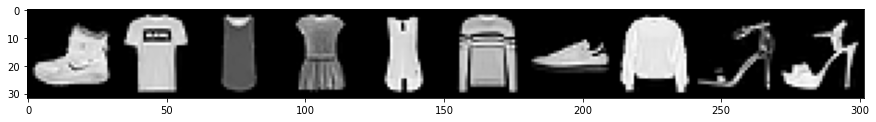

In [9]:
demo_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

grid = torchvision.utils.make_grid(images, nrow=10)
plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")

In [175]:
from skimage.segmentation import slic, quickshift
from skimage.segmentation import mark_boundaries

def torch_img_to_np(torch_img):
    np_img = torch_img.numpy()
    np_img = np.swapaxes(np_img,0,1)
    np_img = np.swapaxes(np_img,1,2)
    return np_img

def np_img_to_torch(np_img):
    torch_img = np.swapaxes(np_img,2,1)
    torch_img = np.swapaxes(torch_img,1,0)
    return torch.from_numpy(torch_img)

print("Test: ", torch.max(torch.abs(ex_img - np_img_to_torch(torch_img_to_np(ex_img)))).item())

def segment_img(torch_img, n_segments=10, compactness=2, sigma=1, start_label=0):
    np_img = torch_img_to_np(torch_img)
    segments_slic = slic(np_img, n_segments=n_segments, compactness=compactness,
                         sigma=sigma, start_label=start_label)
    return np_img, np.repeat(np_img, 3, axis=2), segments_slic

Test:  0.0


In [157]:
sample_idx = 0
ex_img = images[sample_idx]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


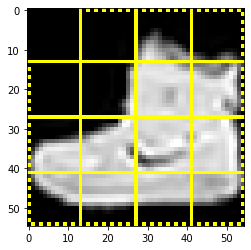

In [158]:
np_img, np_3D_img, segments_slic = segment_img(ex_img, n_segments=16, compactness=100, sigma=1, start_label=0)
plt.imshow(mark_boundaries(np_3D_img, segments_slic, mode = 'subpixel'))

Test:  [1, 1, 1, 1, 1, 1, 1, 0, 1, 1]
Test:  [0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1]
Test:  [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]


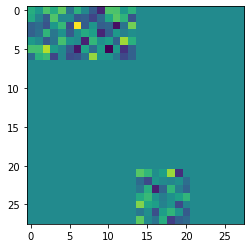

In [159]:
def lime_seed_generator(xai_dim, p = 0.9):
    return list(np.random.choice(2, xai_dim, p=[1-p, p]))

print("Test: ", lime_seed_generator(10, p = 0.9))

def get_perturb_mask(segments_slic ,p = 0.9):
    xai_dim = len(np.unique(segments_slic).tolist())
    seed = lime_seed_generator(xai_dim, p = p)
    perturb_mask = np.zeros_like(segments_slic)
    for key, val in zip(np.unique(segments_slic).tolist(), seed):
        perturb_mask[segments_slic == key] = val
    return seed, 1 - perturb_mask

lime_seed, perturb_mask = get_perturb_mask(segments_slic ,p = 0.8) 
print("Test: ", lime_seed)
plt.imshow(perturb_mask)

def noise_generator(x, segments_slic, p = 0.9, sigma = 1):
    lime_seed, perturb_mask = get_perturb_mask(segments_slic ,p = p) 
    noise = np.random.normal(0, sigma, x.shape)
    return lime_seed, noise*perturb_mask[:,:,None]

lime_seed, noise = noise_generator(np_img, segments_slic ,p = 0.8, sigma = 1) 
print("Test: ", lime_seed)
plt.imshow(noise)

In [209]:
def lime_perturb_gen(torch_img, 
                     no_samples = 1,
                     n_segments=10, slic_compactness=2, slic_sigma=1, start_label=0,
                     perturb_prob = 0.1, perturb_sigma = 1,
                     data_min = 0.0, data_max = 1.0):
    
    np_img, np_3D_img, segments_slic = segment_img(torch_img, 
                                                   n_segments=n_segments, 
                                                   compactness=slic_compactness, 
                                                   sigma=slic_sigma, 
                                                   start_label=0)
    
    xai_dim = len(np.unique(segments_slic).tolist())
    seeds = np.zeros((no_samples, xai_dim))
    perturbations = torch.cat(no_samples*[torch_img.unsqueeze(0)])
    for s in range(no_samples):
        seeds[s], noise = noise_generator(np_img, segments_slic ,
                                           p = 1 - perturb_prob, 
                                           sigma = perturb_sigma)

        perturbations[s] =  torch.clip(perturbations[s] + np_img_to_torch(noise),
                                       min = data_min, max = data_max)
    
    return seeds, perturbations, segments_slic

In [299]:
n_samples = 200

In [300]:
lime_seeds, lime_perturbations, segments_slic = lime_perturb_gen(ex_img, 
                                                                 no_samples = n_samples,
                                                                 n_segments = 16, slic_compactness = 100, 
                                                                 slic_sigma = 1, start_label = 0,
                                                                 perturb_prob = 0.1, perturb_sigma = 1)

In [215]:
from fashion_model import FashionCNN 

checkpt_file = 'pretrained/fashionCNN.pt'
print(checkpt_file)

model = FashionCNN()
model.to(device)
model.load_state_dict(torch.load(checkpt_file))

pretrained/fashionCNN.pt


<All keys matched successfully>

In [ ]:
def lime_explain(f,x, )

In [301]:
original_output = model(ex_img.unsqueeze(0).to(device))
original_prediction = torch.max(original_output, 1)[1]
perturb_outputs = model(lime_perturbations.to(device))
perturb_prediction = torch.max(perturb_outputs, 1)[1]
probs = nn.functional.softmax(perturb_outputs, dim = 1)
perturb_targets = probs[:,original_prediction.item()].cpu().detach().numpy()

In [223]:
def similarity_kernel(v1,v2,kernel_width = 1):
    l2_dist = np.linalg.norm(v1 - v2)
    return np.exp(- (l2_dist**2) / (kernel_width**2))

In [302]:
similarities = [similarity_kernel(lime_perturbations[i], ex_img, kernel_width = 4) for i in range(n_samples)]

In [228]:
from sklearn import linear_model

In [303]:
clf = linear_model.Ridge(alpha = 100)
clf.fit(lime_seeds, perturb_targets, sample_weight=similarities)
explanation = clf.coef_
explanation = (explanation - explanation.min())/(explanation.max() - explanation.min())

In [304]:
explanation_mask = np.zeros_like(segments_slic).astype('float64')
for k, v in zip(np.unique(segments_slic).tolist(), explanation):
    explanation_mask[segments_slic == k] = v

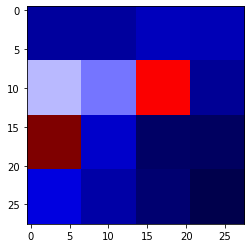

In [306]:
plt.imshow(explanation_mask, cmap=plt.get_cmap('seismic'))